In [0]:
#!mkdir datasets

In [0]:
from __future__ import print_function
from time import time

from keras.models import Model, Sequential

from keras.layers import Input, LSTM, Dense, Bidirectional, Embedding, SpatialDropout1D
import numpy as np
from keras.callbacks import TensorBoard, EarlyStopping

import gc

import tensorflow as tf
from keras import backend as K

num_cores = 4

GPU = True
CPU = True
if GPU:
    num_GPU = 1
    num_CPU = 1
elif CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : num_CPU,
                                        'GPU' : num_GPU}
                       )

session = tf.Session(config=config)
K.set_session(session)


In [41]:
import numpy as np
import pandas as pd

df = pd.read_csv('datasets/dataset.csv')

reviews_title = 'review'
rating_title = 'rating'

reviews_df = df[reviews_title]
ratings_df = df[rating_title]

reviews = reviews_df.iloc[:].copy()
ratings = ratings_df.iloc[:].copy()

print(reviews.shape, ratings.shape)

print(reviews[0:5])
print(ratings[0:5])

(17060,) (17060,)
0    This movie is the beginning of the culmination...
1    Over the past decade, Marvel has earned itself...
2    Summer movies often hype themselves as spectac...
3    I was amazed to see so many negative reviews; ...
4    Infinity War is a astonishing film which serve...
Name: review, dtype: object
0    10
1    10
2    10
3     9
4     7
Name: rating, dtype: int64


In [42]:
import nltk
nltk.download('wordnet')

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# get rid of punctuation and stop words

# reviews = ['this is not the typical mel brooks film it was much less slapstick\
#            than most of his movies and actually had a plot that was followable\
#            leslie ann warren made the movie she is such a fantastic under rated\
#            actress there were some moments that could have been fleshed out a\
#            bit more and some scenes that could probably have been cut to make\
#            the room to do so but all in all this is worth the price to rent\
#            and see it the acting was good overall brooks himself did a good \
#            job without his characteristic speaking to directly to the audience\
#            again warren was the best actor in the movie but fume and sailor both\
#            played their parts well',
#            'batman ;kicked his ass', 'i hated ; this movie.']

reviews_split = []
words = []

stop_words = ['in','of','at','a','the', 'you', 'we', 'your', 'yours', 'his', 'her', 'him', 'me', 'i', 'am', 'is', 'was']
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for review in reviews:
    
    # lowercase, standardize
    review = review.lower()
    
    # remove punct
    review = ''.join([c for c in review if c not in punctuation])
    
    # remove stop words
    review = ' '.join([word for word in review.split() 
                  if word not in stop_words])
    
    # stemming
    # review = ' '.join([stemmer.stem(word) for word in review.split()])
    
    # lammatization
    # review = ' '.join([lemmatizer.lemmatize(word) for word in review.split()])
    
    reviews_split.append(review)
    words.extend(review.split())
    # print(review)
    
    
print(reviews_split[:5][:25])
print()
print(words[:5])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['this movie beginning culmination marvels masterfully woven cinematic universe beginning back 2008 with iron man are finally seeing results all movies have been pointing to and it did not disappoint thanos complex villain with deeper and more interesting desires than just world domination dilemmas all characters face this movie both heroes and villains are truly thought provoking and leave on edge seat no other set movies has beeen so involved so expanded and encompassed so many story linescharacters and previous movies sheer amount star power alone this film insane and they do masterful job weaving all these unique and various characters into common storyline', 'over past decade marvel has earned itself benefit doubt studio has consistently delivered smart funny brave films that both embrace and transcend their comicbook origins 18 blockbuster movies produced since iron 

In [0]:
# feel free to use this import 
from collections import Counter

## Build a dictionary that maps words to integers
counts = Counter(words)

vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# for word, ind in vocab_to_int.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
#     if ind == 0:
#         print(word)

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

In [44]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))
print(len(reviews_ints))
print()

# print tokens in first 1 review
print('Review: ', reviews_split[:1])
print('Tokenized review: ', reviews_ints[:1])


Unique words:  48733
17060

Review:  ['this movie beginning culmination marvels masterfully woven cinematic universe beginning back 2008 with iron man are finally seeing results all movies have been pointing to and it did not disappoint thanos complex villain with deeper and more interesting desires than just world domination dilemmas all characters face this movie both heroes and villains are truly thought provoking and leave on edge seat no other set movies has beeen so involved so expanded and encompassed so many story linescharacters and previous movies sheer amount star power alone this film insane and they do masterful job weaving all these unique and various characters into common storyline']
Tokenized review:  [[4, 5, 373, 7412, 2985, 6623, 5080, 1388, 553, 373, 127, 3629, 9, 1676, 192, 15, 529, 248, 2668, 18, 49, 16, 76, 3982, 2, 1, 3, 68, 10, 1296, 832, 1652, 453, 9, 2197, 1, 40, 215, 11600, 62, 21, 157, 10334, 8531, 18, 64, 522, 4, 5, 265, 579, 1, 1107, 15, 445, 136, 4197, 1

In [45]:
# 1=rated one, 0=not reated label conversion
encoded_labels = np.zeros((len(ratings),10))

encoded_labels.shape

for index in range(len(ratings)):
    encoded_labels[index][ratings[index]-1]=1
    
encoded_labels = encoded_labels.astype(int)

print('Ratings: ', ratings[:5])
print('\n', encoded_labels[0:5])

Ratings:  0    10
1    10
2    10
3     9
4     7
Name: rating, dtype: int64

 [[0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]]


In [46]:
# outlier review stats

review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))


print('Number of reviews before removing outliers: ', len(reviews_ints))

## remove any reviews/labels with zero length from the reviews_ints list.

# get indices of any reviews with length 0
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints), len(encoded_labels))

Zero-length reviews: 2
Maximum review length: 1491
Number of reviews before removing outliers:  17060
Number of reviews after removing outliers:  17058 17058


Now our data is in encoded labels and reviews_ints.
Use `print('Number of reviews after removing outliers: ', reviews_ints.shape, encoded_labels.shape)` to check dimensions.


In [47]:
# sanity checks
print('Number of reviews after removing outliers: ', len(reviews_ints), len(encoded_labels))

Number of reviews after removing outliers:  17058 17058


In [0]:
# pad input so that each review has same length 
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [49]:
# Test your implementation!

seq_length = 400

# seq_length = max([len(x) for x in reviews_ints])
# print(seq_length)

features = pad_features(reviews_ints, seq_length=seq_length)


## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[:30,:seq_length])

[[    0     0     0 ...    80  1322   308]
 [  110   499  2319 ...  2822 21576     2]
 [ 1453    49   797 ...   117   280   941]
 ...
 [    0     0     0 ...  2582  7949     3]
 [    0     0     0 ...    22  1155   526]
 [    0     0     0 ...    10   199   198]]


In [50]:
split_frac = 0.8

## partition data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(13646, 400) 
Validation set: 	(1706, 400) 
Test set: 		(1706, 400)


In [0]:
# Instantiate the model with hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 10
embedding_dim = 50 # to avoid one hot encoding, as there are very large size vocab list
hidden_dim = 128 # hidden layers dimension
n_layers = 2 # no of hidden layers

batch_size = 64
epochs = 25


In [0]:
# stop_words = ['in', 'of', 'at', 'a', 'the']

# ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
# ngram_vectorizer.fit(reviews)

# X = ngram_vectorizer.transform(reviews_split)
# X_test = ngram_vectorizer.transform(reviews_test_clean)

# X_train, X_val, y_train, y_val = train_test_split(
#     X, target, train_size = 0.75
# )

# for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
#     svm = LinearSVC(C=c)
#     svm.fit(X_train, y_train)
#     print ("Accuracy for C=%s: %s" 
#            % (c, accuracy_score(y_val, svm.predict(X_val))))
    
# # Accuracy for C=0.001: 0.88784
# # Accuracy for C=0.005: 0.89456
# # Accuracy for C=0.01: 0.89376
# # Accuracy for C=0.05: 0.89264
# # Accuracy for C=0.1: 0.8928
    
# final = LinearSVC(C=0.01)
# final.fit(X, target)
# print ("Final Accuracy: %s" 
#        % accuracy_score(target, final.predict(X_test)))


In [52]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=features.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 50)           2436700   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 400, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 2,498,110
Trainable params: 2,498,110
Non-trainable params: 0
_________________________________________________________________
None


Train on 12281 samples, validate on 1365 samples
Epoch 1/25
12281/12281 [==============================] - 146s 12ms/step - loss: 2.1023 - acc: 0.2509 - val_loss: 1.8820 - val_acc: 0.3451
Epoch 2/25
12281/12281 [==============================] - 143s 12ms/step - loss: 1.7691 - acc: 0.3772 - val_loss: 1.7685 - val_acc: 0.3648
Epoch 3/25
12281/12281 [==============================] - 144s 12ms/step - loss: 1.5221 - acc: 0.4429 - val_loss: 1.7481 - val_acc: 0.3729
Epoch 4/25
12281/12281 [==============================] - 143s 12ms/step - loss: 1.3697 - acc: 0.4882 - val_loss: 1.8440 - val_acc: 0.3480
Epoch 5/25
12281/12281 [==============================] - 145s 12ms/step - loss: 1.2646 - acc: 0.5212 - val_loss: 1.8367 - val_acc: 0.3516
Epoch 6/25
12281/12281 [==============================] - 143s 12ms/step - loss: 1.1497 - acc: 0.5636 - val_loss: 1.9974 - val_acc: 0.3231
Epoch 7/25
12281/12281 [==============================] - 145s 12ms/step - loss: 1.0598 - acc: 0.5958 - val_loss: 2.0

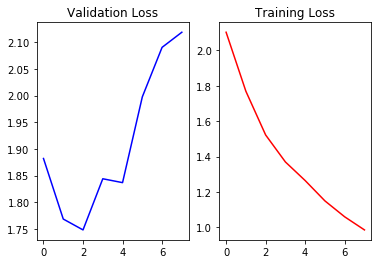

In [53]:
'''

######################################################

model.load_weights('/content/s2s_demorun_demo_1.h5')

######################################################
'''


tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# modify early stopping to save machine state when val loss is min
early = EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1, patience=5)


history = model.fit(train_x, train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_split=0.1, callbacks=[tensorboard, early])

# Save model
model.save('s2s_demorun_demo_1.h5')

# print statistical data
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].plot(history.history['val_loss'], 'b')
ax[0].set_title('Validation Loss')
ax[1].plot(history.history['loss'], 'r')
ax[1].set_title('Training Loss')

plt.show()

model.save('s2s_demorun_demo_1.h5')


In [54]:

for i in range(10):
   # print(x.shape, y.shape)
    pred = model.predict(test_x[i:i+1])
    # print(pred)
    print()
    print('Actual: ', test_y[i:i+1])
    print('Predicted: ', np.argmax(pred)+1)


Actual:  [[1 0 0 0 0 0 0 0 0 0]]
Predicted:  1

Actual:  [[0 0 0 0 0 0 1 0 0 0]]
Predicted:  8

Actual:  [[1 0 0 0 0 0 0 0 0 0]]
Predicted:  6

Actual:  [[0 1 0 0 0 0 0 0 0 0]]
Predicted:  1

Actual:  [[0 1 0 0 0 0 0 0 0 0]]
Predicted:  1

Actual:  [[1 0 0 0 0 0 0 0 0 0]]
Predicted:  1

Actual:  [[1 0 0 0 0 0 0 0 0 0]]
Predicted:  1

Actual:  [[1 0 0 0 0 0 0 0 0 0]]
Predicted:  1

Actual:  [[1 0 0 0 0 0 0 0 0 0]]
Predicted:  2

Actual:  [[0 0 0 0 0 0 0 0 1 0]]
Predicted:  1


In [0]:
from string import punctuation
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = ['in','of','at','a','the', 'you', 'we', 'your', 'yours', 'his', 'her', 'him', 'me', 'i', 'am', 'is', 'was']
seq_length = 400

# pad input so that each review has same length 
def padd_features(review_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((1, seq_length), dtype=int)

    # for each review, I grab that review and 
    # for i, row in enumerate(reviews_ints):
    features[0, -len(review_ints):] = np.array(review_ints)[:seq_length]
    
    return features

def predict_review(review):
    review = review.lower()
    review = ''.join([c for c in review if c not in punctuation])

    # remove stop words
    review = ' '.join([word for word in review.split() 
                  if word not in stop_words])
    
    # stemming
    # review = ' '.join([stemmer.stem(word) for word in review.split()])
    
    # lammatization
    # review = ' '.join([lemmatizer.lemmatize(word) for word in review.split()])
    
    reviews_split.append(review)
    words.extend(review.split())
    # print(review)
  
    #print('After removing punctuations review: ', review)
    review_ints = [vocab_to_int[word] for word in review.split()]
    #print('Encoded review: ', review_ints)
    padded_review_ints = padd_features(review_ints, seq_length)
    #print('Padded and encoded review: ', padded_review_ints)
    #print(padded_review_ints.shape)
    
    pred = model.predict(padded_review_ints)
    # print(pred)
    #print()
    rating_pred = np.argmax(pred)+1
   # print('Predicted: ', rating_pred)
    
    return rating_pred
    

In [65]:

predict_review('I love this movie, nothing new, all boring plot but i enjoyed it !!....')


8

In [66]:
# draw confusion matrix
import tensorflow as tf

df = pd.read_csv('datasets/test.csv')

print(df['rating'][:10])

print(df['review'][:10])


pred = []
labels = []
for i in range(len(df)):
    p = -1
    try:
        p = predict_review(df['review'][i])
    except:
        continue
    if(p>=1 and p<df['rating'][i]):
        pred.append(p-1)
        labels.append(df['rating'][i]-1)
    
print(pred[:5], labels[:5])


conf_mat = tf.confusion_matrix(
    labels,
    pred,
    num_classes=10,
    dtype=tf.dtypes.int32,
    name='Matrix',
    weights=None
)

with tf.Session():
    print(tf.Tensor.eval(conf_mat,feed_dict=None, session=None))

FileNotFoundError: ignored